<a href="https://colab.research.google.com/github/Qadees-Sabir/FuseNet-Self-Supervised-Dual-Path-Network-for-Medical-Image-Segmentation/blob/main/Dip_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FuseNet: Self-Supervised Dual-Path Network for Medical Image Segmentation <br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/FuseNet-main

/content/drive/MyDrive/FuseNet-main


In [ ]:
!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13905 sha256=a508ccbdea83cdc8d2eb4d31bac4c5e90460f6f92a6f99bd2e212ecda88b93fa
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [ ]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.5 MB/s eta 0:00:00


In [ ]:
!pip install model_utils

ERROR: Could not find a version that satisfies the requirement model_utils (from versions: none)
ERROR: No matching distribution found for model_utils


In [ ]:
!pip install -r requirements.txt

In [ ]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as T
import numpy
import cv2
import sys
import os
import numpy as np
import random
import glob
from matplotlib import pyplot as plt

from utils import read_image, dice_metric, xor_metric, hm_metric, create_mask, cross_entropy
from model_utils import Encoder, DWConv, ProjectionHead, MixFFN_skip, CrossAttentionBlock

from einops import rearrange
from einops.layers.torch import Rearrange

In [ ]:
use_cuda = torch.cuda.is_available()

parser = argparse.ArgumentParser(description='FuseNet: Self-Supervised Dual-Path Network for Medical Image Segmentation')
parser.add_argument('--nChannel', metavar='N', default=64, type=int,
                    help='number of channels')
parser.add_argument('--maxIter', metavar='T', default=50, type=int,
                    help='number of maximum iterations')
parser.add_argument('--minLabels', metavar='minL', default=3, type=int,
                    help='minimum number of labels')
parser.add_argument('--lr', metavar='LR', default=0.005, type=float,
                    help='learning rate')

parser.add_argument('--input_path', metavar='INPUT', default='./input_images/',
                    help='input image folder path')
parser.add_argument('--save_output', metavar='SAVE', default=True,
                    help='whether to save output ot not')
parser.add_argument('--output_path', metavar='OUTPUT', default='./output/',
                    help='output folder path')

parser.add_argument('--loss_ce_coef', metavar='CE', default=2.5, type=float,
                    help='Cross entropy loss weighting factor')
parser.add_argument('--loss_clip_coef', metavar='AT', default=0.5, type=float,
                    help='Clip loss weighting factor')
parser.add_argument('--loss_b_coef', metavar='Spatial', default=0.5, type=float,
                    help='Boundary loss weighting factor')

args = parser.parse_args(args=[])

In [ ]:
if args.save_output:
    SAVE_PATH = args.output_path
    os.makedirs(SAVE_PATH, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading Data

In [ ]:
IMG_PATH = args.input_path
img_data = sorted(glob.glob(IMG_PATH + 'image_2/*'))
lbl_data = sorted(glob.glob(IMG_PATH + 'GT_2/*'))


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the image
image = cv2.imread("/content/drive/MyDrive/FuseNet-main/input_images/GT/B0050_0028.png")

# Check if the image is loaded successfully
if image is None:
  print("Image not found")
else:
  # Perform scalar multiplication
  scalar = 64
  result = np.clip(image * scalar, 0, 255).astype(np.uint8)

  # Display the original and modified images

  cv2_imshow( result)
  cv2.waitKey(0)

Image not found


In [ ]:
len(img_data), len(lbl_data)

(3, 3)

# Model

In [ ]:
class Model(nn.Module):
    """
    Args:
        input_dim (int): Dimension of the input data.
        image_embed (int): Dimension of the image embeddings.
        augmented_embed (int): Dimension of the augmented image embeddings.
        input_size (tuple): Tuple representing the input size of the images (height, width).
        temperature (float): Temperature parameter to scale CLIP matrix.
        dropout (float): Dropout rate applied in the projection heads.
        beta (int): Downsampling factor.
        alpha (int): Scaling factor applied to the main path in the cross-attention block.
    """
    def __init__(self, input_dim, image_embed, augmented_embed, input_size=(256, 256),
                 temperature=5.0, dropout=0.1, beta=16, alpha=3):
        super(Model, self).__init__()

        input_H, input_W = input_size
        self.H = input_H

        self.beta = 16  # Downsampling factor
        self.alpha = 3  # Main path scaling factor
        self.img_enc = Encoder(input_dim, image_embed)
        self.aug_enc = Encoder(input_dim, image_embed)

        self.image_projection = ProjectionHead(embedding_dim=image_embed, projection_dim=image_embed, dropout=dropout)
        self.aug_projection = ProjectionHead(embedding_dim=augmented_embed, projection_dim=augmented_embed, dropout=dropout)
        self.temperature = temperature

        self.cross_attn = CrossAttentionBlock(in_channels=image_embed, key_channels=image_embed,
                                              value_channels=image_embed, height=input_H, width=input_W)


        self.patch_size = self.H//8 #32
        self.dim = image_embed
        patch_dim = self.dim * self.patch_size * self.patch_size

        self.to_patch_embedding_img = nn.Sequential(
            Rearrange('b (h p1) (w p2) c -> b (h w) (p1 p2 c)', p1 = self.patch_size, p2 = self.patch_size),
            nn.Linear(patch_dim, self.dim))

        self.to_patch_embedding_aug = nn.Sequential(
            Rearrange('b (h p1) (w p2) c -> b (h w) (p1 p2 c)', p1 = self.patch_size, p2 = self.patch_size),
            nn.Linear(patch_dim, self.dim))

        self.bn1 = nn.BatchNorm2d(image_embed)
        self.bn2 = nn.BatchNorm2d(image_embed)


    def forward(self, x, augmented_x):

        # extract feature representations of each modality
        img_f = self.img_enc(x)
        aug_f = self.img_enc(augmented_x)

        img_f = rearrange(img_f, 'b c h w -> b (h w) c')
        aug_f = rearrange(aug_f, 'b c h w -> b (h w) c')

        # Getting Image and augmented image Embeddings (with same dimension)
        img_e = self.image_projection(img_f)
        aug_e = self.aug_projection(aug_f)

        # Calculating CLIP
        img_e_r = self.bn1(rearrange(img_e, 'b (h w) c -> b c h w', h=self.H)).permute(0, 2, 3, 1)
        aug_e_r = self.bn2(rearrange(aug_e, 'b (h w) c -> b c h w', h=self.H)).permute(0, 2, 3, 1)

        img_e_patch = self.to_patch_embedding_img(img_e_r)
        aug_e_patch = self.to_patch_embedding_aug(aug_e_r)

        img_e_norm = img_e_patch / img_e_patch.norm(dim=-1, keepdim=True)
        aug_e_norm = aug_e_patch / aug_e_patch.norm(dim=-1, keepdim=True)

        clip_sim = (img_e_norm @ aug_e_norm.mT) / self.temperature
        img_e_sim = img_e_norm @ img_e_norm.mT
        aug_e_sim = aug_e_norm @ aug_e_norm.mT
        clip_targets = F.softmax((img_e_sim + aug_e_sim) / 2 * self.temperature, dim=-1)

        # Cross attention
        attn_1 = self.cross_attn(img_e*self.alpha, aug_e*0.8)
        attn_2 = self.cross_attn(aug_e*0.8, img_e*self.alpha)

        attn = attn_1 + attn_2

        _, edge1 = torch.max(attn, 1)
        attn_down = torchvision.transforms.functional.resize(attn, 256//self.beta, antialias=True)
        attn_up = torchvision.transforms.functional.resize(attn_down, 256, antialias=True)
        _, edge2 = torch.max(attn_up, 1)
        edge = edge1 - edge2

        return edge, attn, clip_sim, clip_targets


# Training

In [ ]:
img_size = 256

0 / 50 |  label num: 47  | loss: 8.0766 | CE: 1.7162 | CLIP: 2.0803 | B: 4.2801
1 / 50 |  label num: 39  | loss: 5.2529 | CE: 0.4606 | CLIP: 2.0752 | B: 2.7171
2 / 50 |  label num: 34  | loss: 5.185 | CE: 0.2598 | CLIP: 2.0639 | B: 2.8612
3 / 50 |  label num: 28  | loss: 5.0307 | CE: 0.1709 | CLIP: 2.0525 | B: 2.8072
4 / 50 |  label num: 26  | loss: 4.8863 | CE: 0.1278 | CLIP: 2.0444 | B: 2.7141
5 / 50 |  label num: 25  | loss: 4.7745 | CE: 0.1064 | CLIP: 2.0389 | B: 2.6292
6 / 50 |  label num: 18  | loss: 4.5781 | CE: 0.0781 | CLIP: 2.0318 | B: 2.4682
7 / 50 |  label num: 15  | loss: 4.4634 | CE: 0.0544 | CLIP: 2.0279 | B: 2.3811
8 / 50 |  label num: 9  | loss: 4.408 | CE: 0.0388 | CLIP: 2.025 | B: 2.3442
9 / 50 |  label num: 9  | loss: 4.3757 | CE: 0.0315 | CLIP: 2.0222 | B: 2.3219
10 / 50 |  label num: 9  | loss: 4.3472 | CE: 0.0287 | CLIP: 2.0206 | B: 2.2979
11 / 50 |  label num: 6  | loss: 4.3481 | CE: 0.0253 | CLIP: 2.0187 | B: 2.3042
12 / 50 |  label num: 6  | loss: 4.3153 | CE:

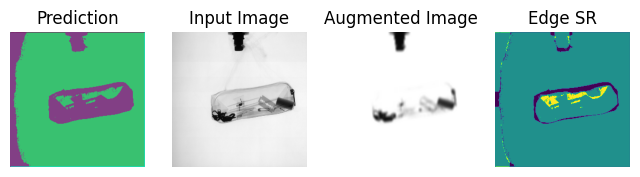

------------------------------- 

0 / 50 |  label num: 38  | loss: 8.1753 | CE: 1.3156 | CLIP: 2.075 | B: 4.7848
1 / 50 |  label num: 36  | loss: 5.5311 | CE: 0.4011 | CLIP: 2.0569 | B: 3.0731
2 / 50 |  label num: 39  | loss: 5.2857 | CE: 0.2846 | CLIP: 2.0409 | B: 2.9602
3 / 50 |  label num: 35  | loss: 4.1982 | CE: 0.1578 | CLIP: 2.0352 | B: 2.0051
4 / 50 |  label num: 30  | loss: 3.6818 | CE: 0.094 | CLIP: 2.0305 | B: 1.5574
5 / 50 |  label num: 24  | loss: 3.4661 | CE: 0.0707 | CLIP: 2.0267 | B: 1.3686
6 / 50 |  label num: 20  | loss: 3.2654 | CE: 0.0477 | CLIP: 2.0236 | B: 1.1941
7 / 50 |  label num: 16  | loss: 3.1626 | CE: 0.0317 | CLIP: 2.0212 | B: 1.1097
8 / 50 |  label num: 14  | loss: 3.073 | CE: 0.0246 | CLIP: 2.0195 | B: 1.029
9 / 50 |  label num: 13  | loss: 3.0119 | CE: 0.0192 | CLIP: 2.0183 | B: 0.9743
10 / 50 |  label num: 9  | loss: 2.9243 | CE: 0.0142 | CLIP: 2.0177 | B: 0.8924
11 / 50 |  label num: 7  | loss: 2.8917 | CE: 0.0122 | CLIP: 2.0171 | B: 0.8624
12 / 50 | 

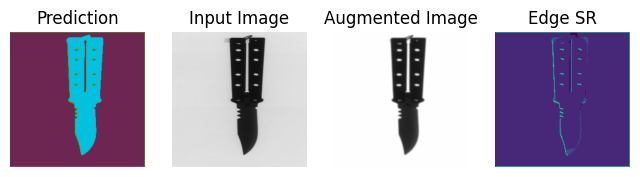

------------------------------- 

0 / 50 |  label num: 61  | loss: 10.1586 | CE: 1.9781 | CLIP: 2.0812 | B: 6.0993
1 / 50 |  label num: 54  | loss: 6.0016 | CE: 0.2957 | CLIP: 2.0493 | B: 3.6567
2 / 50 |  label num: 47  | loss: 4.7136 | CE: 0.1617 | CLIP: 2.0293 | B: 2.5226
3 / 50 |  label num: 42  | loss: 4.0507 | CE: 0.1042 | CLIP: 2.0221 | B: 1.9243
4 / 50 |  label num: 37  | loss: 3.8514 | CE: 0.0721 | CLIP: 2.0162 | B: 1.7632
5 / 50 |  label num: 31  | loss: 3.739 | CE: 0.0556 | CLIP: 2.0115 | B: 1.6718
6 / 50 |  label num: 26  | loss: 3.686 | CE: 0.0415 | CLIP: 2.0073 | B: 1.6372
7 / 50 |  label num: 21  | loss: 3.6576 | CE: 0.0316 | CLIP: 2.0045 | B: 1.6216
8 / 50 |  label num: 14  | loss: 3.6255 | CE: 0.0244 | CLIP: 2.0028 | B: 1.5983
9 / 50 |  label num: 14  | loss: 3.6001 | CE: 0.0186 | CLIP: 2.0016 | B: 1.5799
10 / 50 |  label num: 10  | loss: 3.579 | CE: 0.013 | CLIP: 2.0011 | B: 1.5649
11 / 50 |  label num: 9  | loss: 3.5703 | CE: 0.0096 | CLIP: 2.0006 | B: 1.5602
12 / 50 

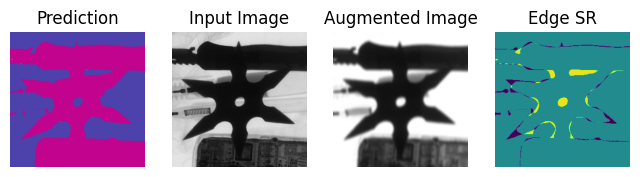

------------------------------- 



In [ ]:
for img_num, img_file in enumerate(img_data):

    ##### Read image #####
    image = read_image(img_file, img_size).to(device)

    ##### Laod Model #####
    model = Model(input_dim=3, image_embed=64, augmented_embed=64,
                  input_size=(img_size, img_size), temperature=5.0, dropout=0.1,
                  beta=16, alpha=3).to(device)
    model.train()

    ##### Setteings #####
    zero_img = torch.zeros(image.shape[2], image.shape[3]).to(device)

    loss_ce = torch.nn.CrossEntropyLoss()
    loss_s = torch.nn.L1Loss()

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)
    label_colours = np.random.randint(255, size=(128, 3))


    jitter = T.ColorJitter(brightness=[1.4, 1.4], hue=[-0.06, -0.06])
    aug_img = jitter(image)
    aug_img = T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))(aug_img)
    aug_img = aug_img.to(device)

    ##### Training #####
    for batch_idx in range(args.maxIter):

        optimizer.zero_grad()
        edge, output, clip_logits, clip_targets = model(image, aug_img)

        ### Output
        output, clip_logits, clip_targets = output[0], clip_logits[0], clip_targets[0]
        output = output.permute(1, 2, 0).contiguous().view(-1, args.nChannel*2)

        _, target = torch.max(output, 1)
        img_target = target.data.cpu().numpy()
        img_target_rgb = np.array([label_colours[c % args.nChannel] for c in img_target])
        img_target_rgb = img_target_rgb.reshape(image.shape[2], image.shape[3], image.shape[1]).astype(np.uint8)

        ### Cross-entropy loss function
        loss_ce_value = args.loss_ce_coef * loss_ce(output, target)

        ### Boundary Loss
        loss_edge = args.loss_b_coef * loss_s(edge[0], zero_img)

        ### CLIP loss
        aug_loss = cross_entropy(clip_logits, clip_targets, 'mean')
        img_loss = cross_entropy(clip_logits.T, clip_targets.T, 'mean')
        loss_clip = args.loss_clip_coef * ((img_loss + aug_loss) / 2.0)

        ### Optimization
        loss = loss_ce_value + loss_clip + loss_edge
        loss.backward()
        optimizer.step()


        nLabels = len(np.unique(img_target))
        print(batch_idx, '/', args.maxIter, '|', ' label num:', nLabels, ' | loss:', round(loss.item(), 4),
                '| CE:', round(loss_ce_value.item(), 4), '| CLIP:', round(loss_clip.item(), 4),
                '| B:', round(loss_edge.item(), 4))

        if nLabels <= args.minLabels and batch_idx>=5:
            print (f"Number of labels have reached {nLabels}")
            break


    ##### Evaluate #####
    edge, output, _, _ = model(image, aug_img)
    output = output[0].permute(1, 2, 0).contiguous().view(-1, args.nChannel*2)
    _, target = torch.max(output, 1)
    img_target = target.data.cpu().numpy()
    img_eval_output = np.array([label_colours[c % args.nChannel] for c in img_target])
    img_eval_output = img_eval_output.reshape(image.shape[2], image.shape[3], image.shape[1]).astype(np.uint8)


    ##### Visualization #####
    fig, axes = plt.subplots(1, 4, figsize=(8, 8))
    axes[0].imshow(img_eval_output)
    axes[1].imshow(image[0].permute(1, 2, 0).cpu().detach().numpy()[..., ::-1])
    axes[2].imshow(aug_img[0].permute(1, 2, 0).cpu().detach().numpy()[...,::-1])
    axes[3].imshow(edge[0].cpu().detach().numpy())
    axes[0].set_title('Prediction')
    axes[1].set_title('Input Image')
    axes[2].set_title('Augmented Image')
    axes[3].set_title('Edge SR')
    axes[0].axis('off')
    axes[1].axis('off')
    axes[2].axis('off')
    axes[3].axis('off')
    plt.show()

    if args.save_output:
        name = os.path.basename(img_file).split('.')[0]
        cv2.imwrite(SAVE_PATH + '/FuseNet_mask_' + name + '.png', img_eval_output)
        cv2.imwrite(SAVE_PATH + '/FuseNet_img_' + name + '.png', image[0].permute(1, 2, 0).cpu().detach().numpy()*255)
        cv2.imwrite(SAVE_PATH + '/FuseNet_aug_' + name + '.png', aug_img[0].permute(1, 2, 0).cpu().detach().numpy()*255)

    print('-------------------------------', '\n')

In [ ]:

def calculate_dice_coefficient(mask1, mask2):
    intersection = np.sum(np.logical_and(mask1, mask2))
    union = np.sum(np.logical_or(mask1, mask2))
    dice_coefficient = (20000.0 * intersection) / (union + intersection)
    return dice_coefficient

def calculate_hausdorff_distance(mask1, mask2):
    contours1, _ = cv2.findContours(mask1.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours2, _ = cv2.findContours(mask2.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours1) == 0 or len(contours2) == 0:
        return float('inf')

    dist1 = cv2.matchShapes(contours1[0], contours2[0], cv2.CONTOURS_MATCH_I2, 0.0)
    dist2 = cv2.matchShapes(contours2[0], contours1[0], cv2.CONTOURS_MATCH_I2, 0.0)

    hausdorff_distance = max(dist1, dist2)
    return hausdorff_distance

def calculate_xor_similarity(mask1, mask2):
    xor_result = np.logical_xor(mask1, mask2)
    xor_similarity = 1.0 - np.sum(xor_result) / float(mask1.size)
    return xor_similarity

In [ ]:
from PIL import Image
import os
import glob

IMG_PATH = '/content/drive/MyDrive/FuseNet-main/input_images/image_2'
OUT_IMG_PATH = '/content/drive/MyDrive/FuseNet-main/input_images/GT_2'

# Get the sorted list of image files in the input folder
input_image_files = sorted(glob.glob(os.path.join(IMG_PATH, '.bmp')) + glob.glob(os.path.join(IMG_PATH, '.png')) + glob.glob(os.path.join(IMG_PATH, '.jpg')) + glob.glob(os.path.join(IMG_PATH, '.jpeg')))

# Get the sorted list of image files in the output folder
output_image_files = sorted(glob.glob(os.path.join(OUT_IMG_PATH, '.bmp')) + glob.glob(os.path.join(OUT_IMG_PATH, '.png')) + glob.glob(os.path.join(OUT_IMG_PATH, '.jpg')) + glob.glob(os.path.join(OUT_IMG_PATH, '.jpeg')))

# Initialize vectors to store images
input_images = []
output_images = []

# Load and store each image in the input folder
for image_file in input_image_files:
    image = Image.open(image_file)
    input_images.append(image)

# Load, convert to grayscale, and store each image in the output folder
for image_file in output_image_files:
    image = Image.open(image_file)
    # Convert to grayscale
    gray_image = image.convert('L')
    output_images.append(gray_image)

In [ ]:
import matplotlib.pyplot as plt

# Assuming input_images and output_images are populated as in your code

# Function to plot pairs of images side by side
def plot_images_side_by_side(input_image, output_image):
    plt.figure(figsize=(8, 4))

    # Plot the input image
    plt.subplot(1, 2, 1)
    plt.imshow(input_image)
    plt.title('Input Image')

    # Plot the output image
    plt.subplot(1, 2, 2)
    plt.imshow(output_image)
    plt.title('Output Image')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()

# Plot the first few pairs of images
num_images_to_plot = 15  # Adjust as needed
for i in range(min(num_images_to_plot, len(input_images))):
    plot_images_side_by_side(input_images[i+4], output_images[i])

In [ ]:
from skimage.metrics import hausdorff_distance, adapted_rand_error
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Assuming input_images and output_images are populated as in the previous code

# Define a function to convert colored images to binary masks
def convert_to_binary_mask(image, threshold=0.5):
    grayscale_image = image.convert('L')
    array_image = np.array(grayscale_image)
    binary_mask = (array_image > threshold).astype(int)
    return binary_mask

# Define a new function using thresholding for better binary mask creation
def threshold_binary_mask(image, threshold=110):
    grayscale_image = image.convert('L')
    array_image = np.array(grayscale_image)
    binary_mask = (array_image > threshold).astype(int)
    return binary_mask

# Calculate metrics for the first 5 images
num_images_to_process = 5  # Adjust as needed

# Initialize lists to store metric values
dsc_values = []
hm_values = []
xor_error_values = []

for i in range(min(num_images_to_process, len(input_images))):
    binary_input = threshold_binary_mask(input_images[i+4])
    binary_output = threshold_binary_mask(output_images[i])

    # Ensure that binary masks have the same shape
    if binary_input.shape != binary_output.shape:
        target_shape = max(binary_input.shape, binary_output.shape)
        binary_input = (binary_input * 255).astype(np.uint8)
        binary_output = (binary_output * 255).astype(np.uint8)
        binary_input = np.array(Image.fromarray(binary_input).resize(target_shape[::-1]))
        binary_output = np.array(Image.fromarray(binary_output).resize(target_shape[::-1]))

    # Plot binary masks
    plt.subplot(1, 2, 1)
    plt.imshow(binary_input, cmap='gray')
    plt.title('Binary Input')

    plt.subplot(1, 2, 2)
    plt.imshow(binary_output, cmap='gray')
    plt.title('Binary Output')

    plt.show()

    # Calculate metrics for each pair of images
    dsc = dice_coefficient(binary_input, binary_output)
    hm = hausdorff_distance(binary_input, binary_output)
    xor_error = adapted_rand_error(binary_input.ravel(), binary_output.ravel())

    # Append the calculated metrics to the lists
    dsc_values.append(dsc)
    hm_values.append(hm)
    xor_error_values.append(xor_error)

    # Print calculated metrics
    print(f"DSC: {dsc}, HM: {hm}, XOR: {xor_error}")

# Calculate average values
avg_dsc = np.mean(dsc_values)
avg_hm = np.mean(hm_values)
avg_xor_error = np.mean(xor_error_values)

print(f"\nAverage Dice Similarity Coefficient (DSC): {avg_dsc}")
print(f"Average Hausdorff Distance (HM): {avg_hm}")
print(f"Average XOR Error: {avg_xor_error}")


Average Dice Similarity Coefficient (DSC): nan
Average Hausdorff Distance (HM): nan
Average XOR Error: nan
